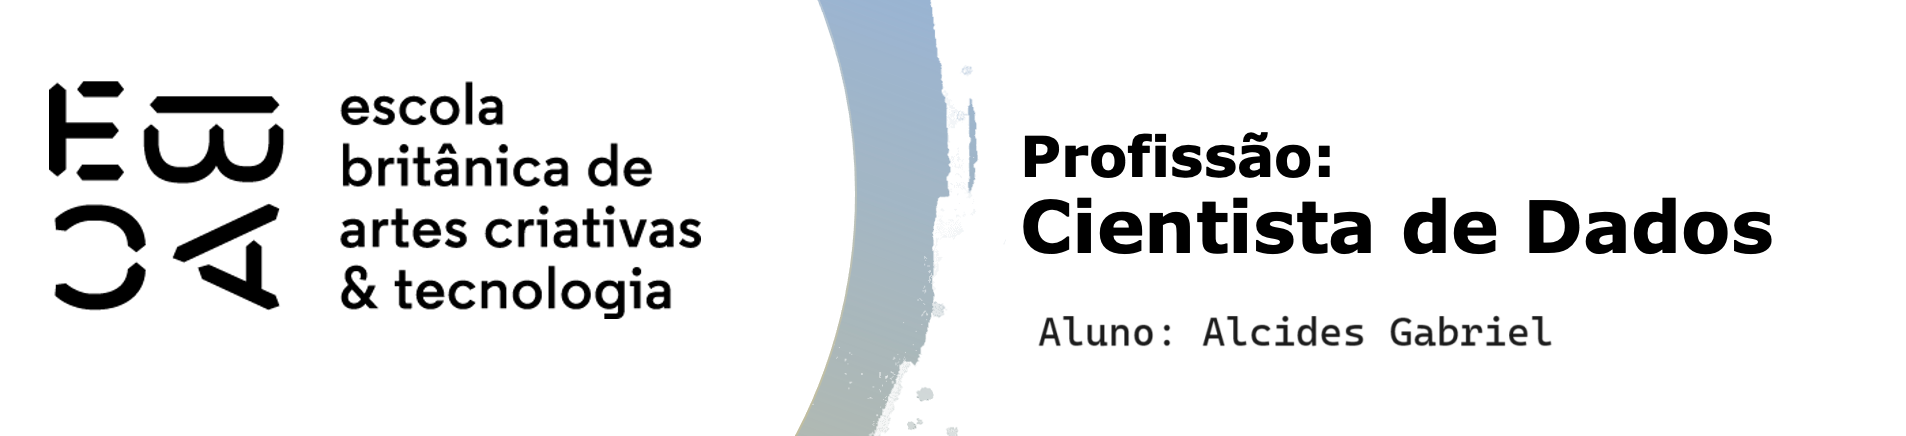

# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
from sklearn.metrics import classification_report, roc_curve, auc
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def analise(data, resposta: str, explicativa: str, quantitativo = False, num_class = 5) -> list:
    """
    Função criada para retornar um dataframe para a análise dos dados.
    """ 
    
    
    # Cópia de segurança
    dt = data.copy()
    # Criar dummie do alvo
    dt = pd.get_dummies(dt, columns=[resposta]).rename(columns={'flag_doente_0':'doente','flag_doente_1':'saudavel'})
    
    # Mudar o atributo sexo.
    change = {0:'Feminino',1:'Masculino'}
    dt['sex'] = dt['sex'].map(change)
    
    # Definindo um dataframegroupby
    if quantitativo == True:
        dt[f'{explicativa}_categorica'] = pd.qcut(dt[explicativa], q=num_class)
        group_df = dt.groupby(f'{explicativa}_categorica')
    else:
        group_df = dt.groupby(explicativa)
        
    # Aplicando filtros.
    dt_analise = group_df[['doente','saudavel']].sum()
    dt_analise['total'] = dt_analise.sum(1)
    dt_analise['media'] = group_df['doente'].mean()
    dt_analise['chance_(odds)'] = dt_analise['saudavel'] / dt_analise['doente']
    # Taxa de ODDs
    dt_analise['taxa_chance'] = dt_analise['total'] / dt_analise['chance_(odds)']
    # Logito
    dt_analise['log_chance'] = np.log(dt_analise['chance_(odds)'])
    # Weight of Evidence
    dt_analise['WOE'] = np.log(dt_analise['taxa_chance'])
    
    return dt_analise

In [5]:
analise(df, 'flag_doente', 'sex')

,doente,saudavel,total,media,chance_(odds),taxa_chance,log_chance,WOE
sex,,,,,,,,
Feminino,72,25,97,0.742268,0.347222,279.360000,-1.05779,5.632501
Masculino,92,114,206,0.446602,1.239130,166.245614,0.21441,5.113466


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [6]:
analise(df, 'flag_doente', 'age', True)

,doente,saudavel,total,media,chance_(odds),taxa_chance,log_chance,WOE
age_categorica,,,,,,,,
"(28.999, 45.0]",47,16,63,0.746032,0.340426,185.062500,-1.077559,5.220694
"(45.0, 53.0]",42,22,64,0.656250,0.523810,122.181818,-0.646627,4.805510
"(53.0, 58.0]",32,39,71,0.450704,1.218750,58.256410,0.197826,4.064854
"(58.0, 62.0]",13,32,45,0.288889,2.461538,18.281250,0.900787,2.905876
"(62.0, 77.0]",30,30,60,0.500000,1.000000,60.000000,0.000000,4.094345


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [7]:
def modelo_clf(data, resposta: str, explicativa: str, cat_num: str) -> None:
    dt = data.copy()
    
    dt[cat_num] = pd.qcut(dt[cat_num], q = 5)
    
    variaveis = f'{resposta} ~ {explicativa}'
    clf = smf.logit(variaveis, data=dt).fit()
    display(clf.summary())
    return clf

In [8]:
clf = modelo_clf(df, 'flag_doente','C(sex) + C(cp) + C(trestbps) + age', 'trestbps')

Optimization terminated successfully.
         Current function value: 0.475760
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.3102
Time:                        10:31:43   Log-Likelihood:                -144.16
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.385e-23
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -6.1102      1.266     -4.825      0.000      -8.592      -3.628
C(sex)[T.1.0]                                             1.7656      0.355      4.970      0.000       1.069       2.462
C(cp)[T.2.0]                                             -0.1130      0.641     -0.176      0.860      -1.369       1.143
C(cp)[T.3.0]                                              0.0319      0.574      0.056      0.956      -1.092       1.156
C(cp)[T.4.0]                                              2.4582      0.554      4.439      0.000       1.373       3.544
C(trestbps)[T.Interval(120.0, 126.0, closed='right')]     0.7024      0.577      1.216      0.224      -0.429       1.834
C(trestbps)[T.Interval(126.0, 134.0, closed='right')]     0.4722      0.423      1.116      0.264      -0.357       1.301
C(trestbps)[T.Interval(134.0, 144.6, closed='right')]     0.0266      0.439      0.061      0.952      -0.833       0.886
C(trestbps)[T.Interval(144.6, 200.0, closed='right')]     0.8580      0.437      1.963      0.050       0.001       1.715
age                                                       0.0573      0.019      3.086      0.002       0.021       0.094
=========================================================================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [9]:
def avaliacao(data ,modelo, tipo = 'graf') -> str:
    # Modelo previsão
    # Criação do modelo.
    dt = data.copy()
    
    dt['prev'] = modelo.predict()
    dt['trestbps'] = pd.qcut(dt['trestbps'], q = 5)
    dt_analise = pd.DataFrame()
    dt_analise['real'] = dt['flag_doente']
    dt_analise['prev'] =  modelo.predict(dt[['trestbps','sex','cp','age']])
    dt_analise['prev_class'] = pd.qcut(dt_analise['prev'], q=5)
    dt_analise['prev_round'] = [1 if i >= 0.5 else 0 
                                for i in dt_analise['prev']]
    
    ## análise de resultados
    gb = dt_analise.groupby('prev_class')
    gb_an = gb[['real']].count().rename(columns={'real':'Contagem'})
    gb_an['media_real'] = gb['real'].mean()
    gb_an['media_prev'] = gb['prev'].mean()
    
    if tipo == 'graf':
        display(gb_an)
        return gb_an.reset_index()
    else:
        return dt_analise

In [10]:
resultado = avaliacao(df, clf)

,Contagem,media_real,media_prev
prev_class,,,
"(0.0127, 0.126]",61,0.065574,0.067197
"(0.126, 0.308]",60,0.183333,0.210336
"(0.308, 0.6]",61,0.491803,0.437707
"(0.6, 0.819]",60,0.683333,0.701049
"(0.819, 0.962]",61,0.868852,0.877340


In [11]:
def imagem_() -> None:
    
    fig = plt.figure(figsize=(10,8))
    fig.suptitle('Gráfico de comparação', fontsize=25)
    res = resultado.melt(id_vars='prev_class', value_vars=['media_real','media_prev'])
    res['prev_class'] = res['prev_class'].astype(str)
    sns.lineplot(data=res, x='prev_class',y='value', hue='variable')
    return plt.show()    

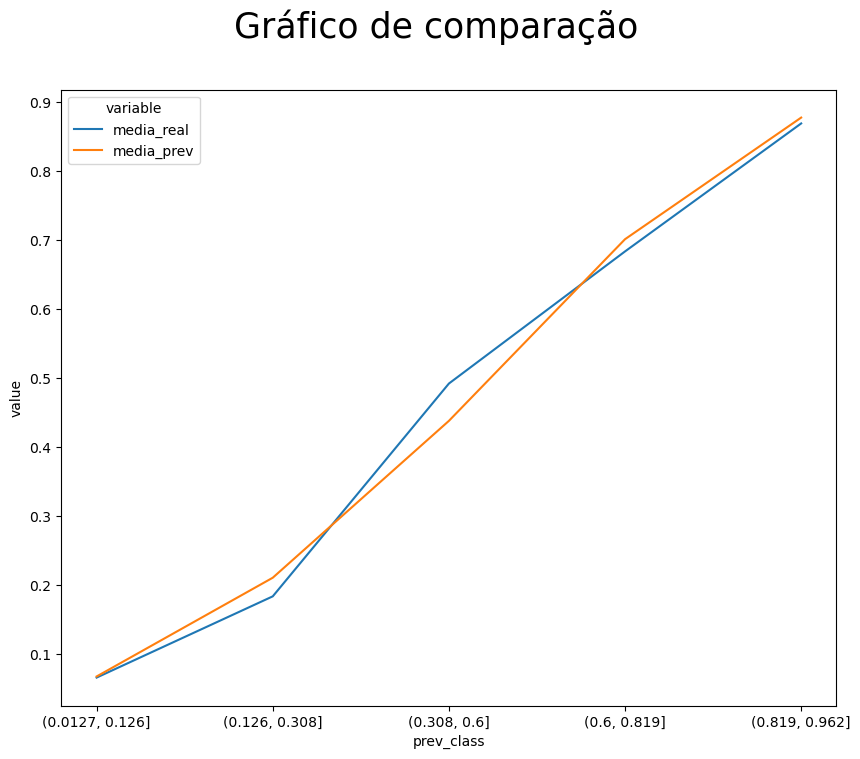

In [12]:
imagem_()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [13]:
def resultados():
    resultado = avaliacao(df, clf,'outro')
    real = resultado['real']
    prev = resultado['prev']
    print(classification_report(real, resultado['prev_round']))
    
    # AUC
    fpr, tpr, threshold = roc_curve(real, prev)
    auc_ = auc(fpr, tpr)
    # Gini
    gini = 2*auc_ - 1
    
    # PLot
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve', linestyle='-')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.show()

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       164
           1       0.76      0.74      0.75       139

    accuracy                           0.77       303
   macro avg       0.77      0.77      0.77       303
weighted avg       0.77      0.77      0.77       303



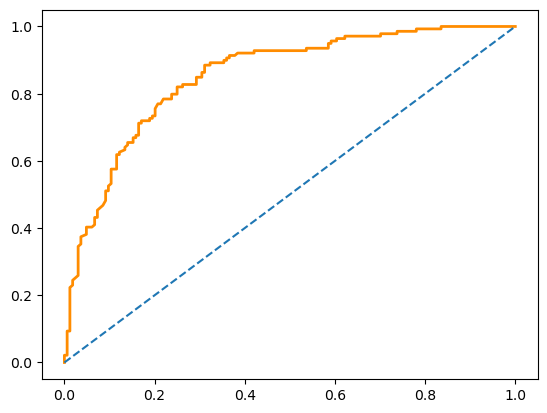

In [14]:
resultados()

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [15]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [17]:
clf = modelo_clf(df, 'flag_doente','C(sex) + C(cp) + C(trestbps) + oldpeak + age', 'trestbps')

Optimization terminated successfully.
         Current function value: 0.429087
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      292
Method:                           MLE   Df Model:                           10
Date:                Mon, 20 Nov 2023   Pseudo R-squ.:                  0.3779
Time:                        10:34:03   Log-Likelihood:                -130.01
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 8.561e-29
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -6.6888      1.331     -5.027      0.000      -9.297      -4.081
C(sex)[T.1.0]                                             1.7047      0.380      4.488      0.000       0.960       2.449
C(cp)[T.2.0]                                              0.7446      0.684      1.089      0.276      -0.596       2.085
C(cp)[T.3.0]                                              0.2528      0.605      0.418      0.676      -0.933       1.439
C(cp)[T.4.0]                                              2.7005      0.585      4.617      0.000       1.554       3.847
C(trestbps)[T.Interval(120.0, 126.0, closed='right')]     0.8170      0.588      1.389      0.165      -0.336       1.970
C(trestbps)[T.Interval(126.0, 134.0, closed='right')]     0.4223      0.439      0.962      0.336      -0.438       1.282
C(trestbps)[T.Interval(134.0, 144.6, closed='right')]     0.0293      0.473      0.062      0.951      -0.897       0.956
C(trestbps)[T.Interval(144.6, 200.0, closed='right')]     0.7658      0.464      1.652      0.099      -0.143       1.675
oldpeak                                                   0.8056      0.169      4.771      0.000       0.475       1.137
age                                                       0.0486      0.019      2.543      0.011       0.011       0.086
=========================================================================================================================
"""

In [18]:
def avaliacao(data ,modelo, tipo = 'graf') -> str:
    # Modelo previsão
    # Criação do modelo.
    dt = data.copy()
    
    dt['prev'] = modelo.predict()
    dt['trestbps'] = pd.qcut(dt['trestbps'], q = 5)
    dt_analise = pd.DataFrame()
    dt_analise['real'] = dt['flag_doente']
    dt_analise['prev'] =  modelo.predict(dt[['trestbps','sex','cp','age','oldpeak']])
    dt_analise['prev_class'] = pd.qcut(dt_analise['prev'], q=5)
    dt_analise['prev_round'] = [1 if i >= 0.5 else 0 
                                for i in dt_analise['prev']]
    
    ## análise de resultados
    gb = dt_analise.groupby('prev_class')
    gb_an = gb[['real']].count().rename(columns={'real':'Contagem'})
    gb_an['media_real'] = gb['real'].mean()
    gb_an['media_prev'] = gb['prev'].mean()
    
    if tipo == 'graf':
        display(gb_an)
        return gb_an.reset_index()
    else:
        return dt_analise

In [19]:
resultado = avaliacao(df, clf)

,Contagem,media_real,media_prev
prev_class,,,
"(0.0086, 0.102]",61,0.049180,0.052057
"(0.102, 0.289]",60,0.200000,0.174045
"(0.289, 0.578]",61,0.393443,0.425714
"(0.578, 0.854]",60,0.716667,0.715574
"(0.854, 0.993]",61,0.934426,0.925881


              precision    recall  f1-score   support

           0       0.80      0.83      0.82       164
           1       0.79      0.76      0.78       139

    accuracy                           0.80       303
   macro avg       0.80      0.80      0.80       303
weighted avg       0.80      0.80      0.80       303



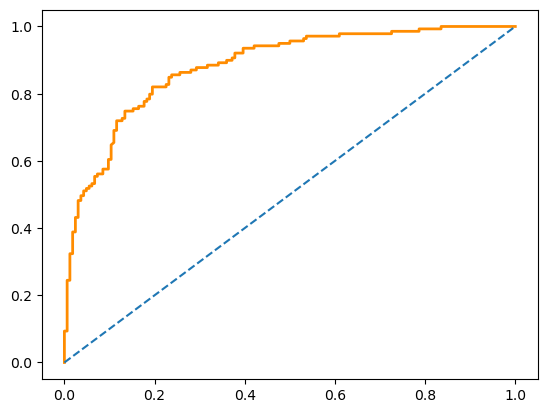

In [20]:
resultados()